In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!ls /content/MyDrive/MyDrive/GEE_SOP/Dataset

Datasets.cpg  Datasets.prj  Datasets.shp  Data_to_Analyze.csv
Datasets.dbf  Datasets.qmd  Datasets.shx


In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.7 MB/s eta 0:00:00


In [ ]:
import importlib.util

spec = importlib.util.spec_from_file_location("script", '/content/MyDrive/MyDrive/GEE_SOP/modules/script.py')
script_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(script_module)

script_module.Script.work()

it's working!


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

path = '/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv'

#sob_data = gpd.read_file(sob_shapefile_path)
data = pd.read_csv(path)

median_mnt1 = data['MNT_1'].median()
data['MNT_1'] = data['MNT_1'].fillna(median_mnt1)

In [ ]:
data = data.drop(columns=['Unnamed: 0', 'X_Centroid', 'Y_Centroid','geometry'])
data.columns

Index(['Carbon', 'Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5',
       'B_6', 'B_7', 'B_8', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1',
       'NDVI', 'GDVI', 'MSAVI2', 'PSRINIR', 'NDWI', 'CIGreen'],
      dtype='object')

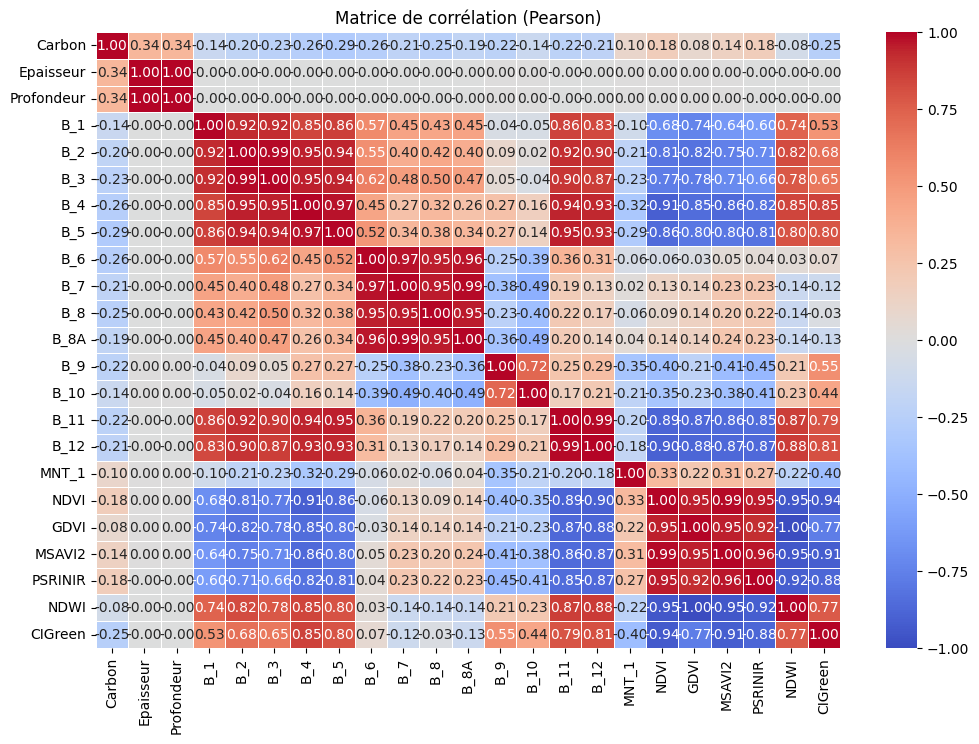

In [ ]:
correlation_matrix = data.corr(method="pearson")

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Pearson)")

# Afficher la figure
plt.show()

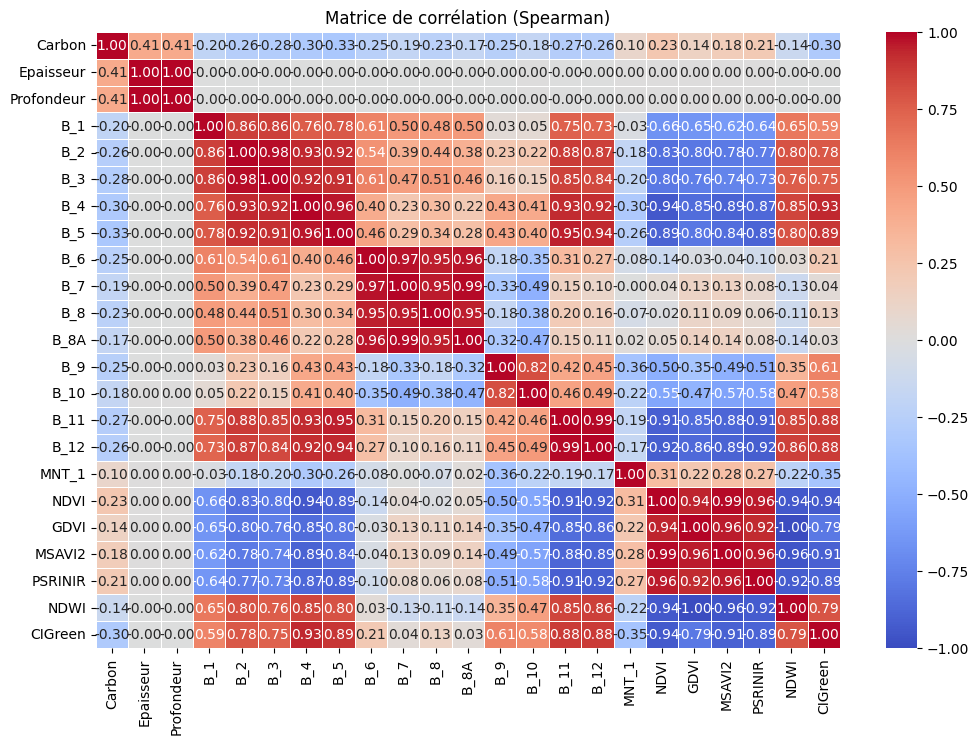

In [ ]:
correlation_matrix = data.corr(method='spearman')

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Spearman)")

# Afficher la figure
plt.show()


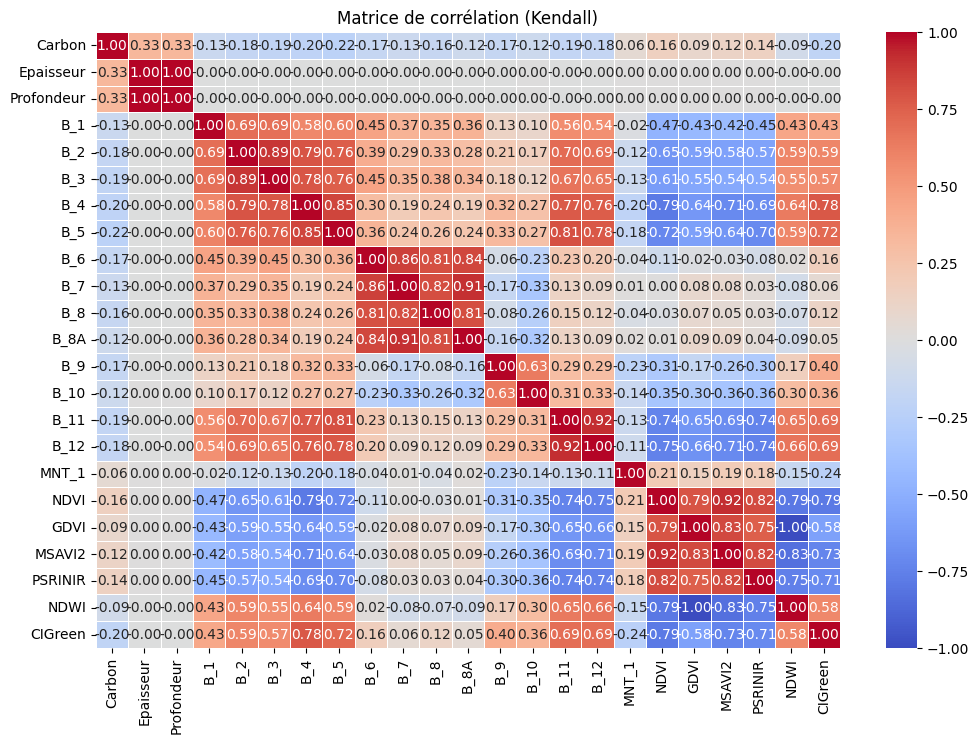

In [ ]:
correlation_matrix = data.corr(method='kendall')

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Kendall)")

# Afficher la figure
plt.show()

In [ ]:
import numpy as np

X = np.array(data.drop(columns=['Carbon']))
Y = np.array(data['Carbon'])

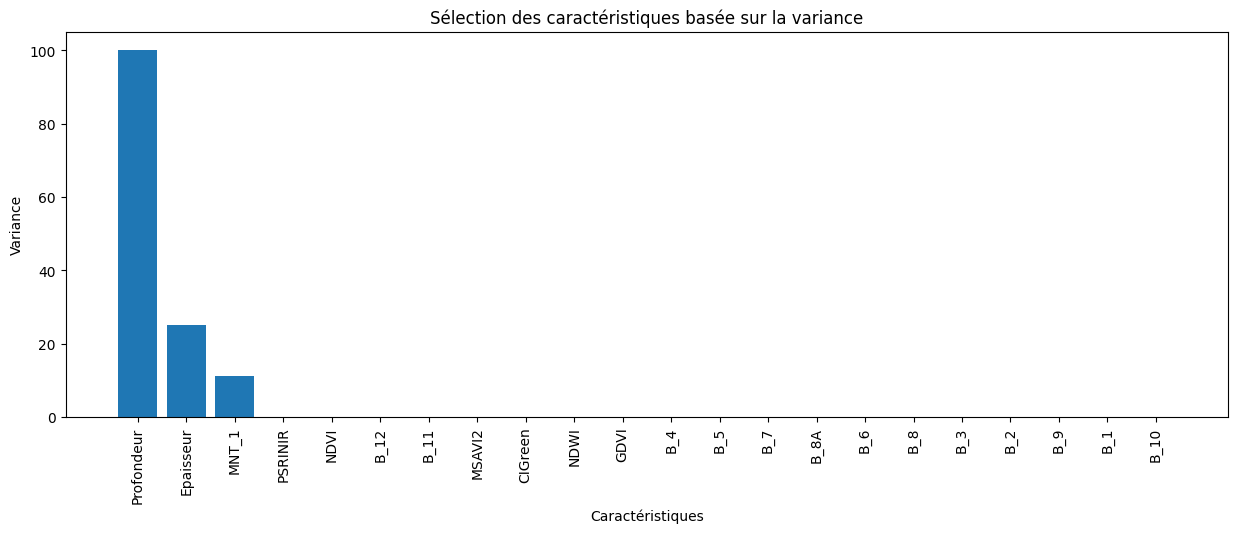

In [ ]:
variances = np.var(X, axis=0)
sorted_indices = np.argsort(variances)[::-1]

# Obtenir les noms des colonnes
columns = data.drop(columns=['Carbon']).columns

# Afficher la courbe des variances
plt.figure(figsize=(15, 5))
plt.bar(x=columns[sorted_indices], height=variances[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Variance')
plt.title('Sélection des caractéristiques basée sur la variance')
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

# Sélectionner les meilleures caractéristiques avec SelectKBest et ANOVA
best_features = SelectKBest(score_func=f_regression, k=6)
X_new = best_features.fit_transform(X, Y)
selected_features = columns[best_features.get_support()]

print('Les meilleures caractéristiques sont :', selected_features)

Les meilleures caractéristiques sont : Index(['Epaisseur', 'Profondeur', 'B_4', 'B_5', 'B_6', 'CIGreen'], dtype='object')


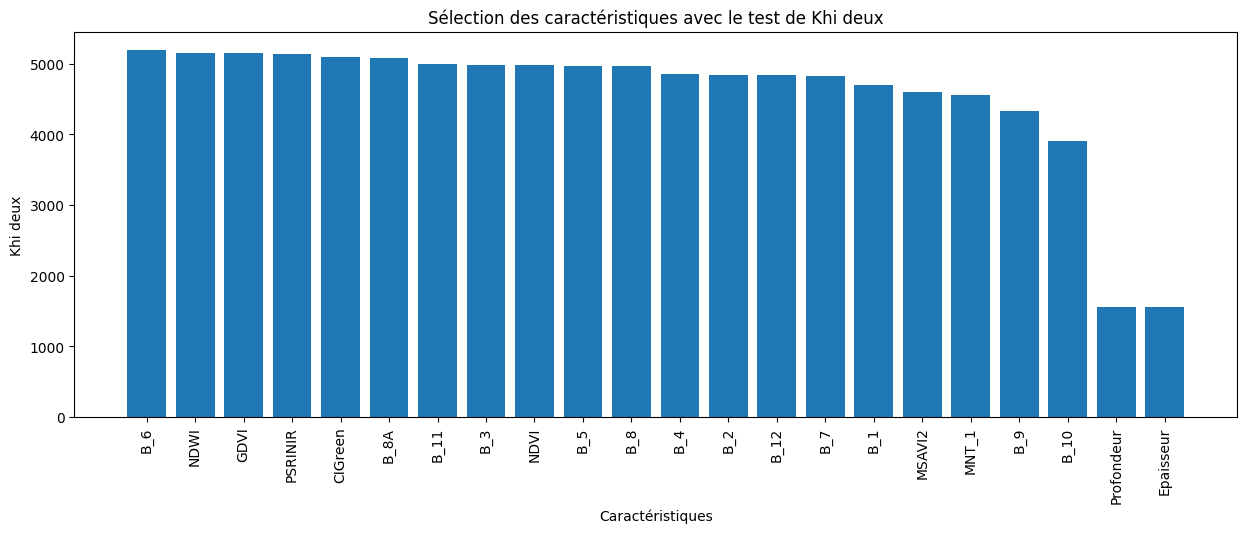

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency


# Discrétiser les colonnes
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_discrete = discretizer.fit_transform(X)

# Calculer les scores de Khi deux pour chaque caractéristique
chi2_scores = np.array([chi2_contingency(pd.crosstab(X_discrete[:, i], Y))[0] for i in range(X_discrete.shape[1])])
sorted_indices = np.argsort(chi2_scores)[::-1]

# Afficher la courbe des scores de Khi deux
plt.figure(figsize=(15, 5))
plt.bar(x=columns[sorted_indices], height=chi2_scores[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel("Khi deux")
plt.title('Sélection des caractéristiques avec le test de Khi deux')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Créer un objet modèle de régression linéaire
regression_model = LinearRegression()

# Forward Selection
sfs = SFS(regression_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs = sfs.fit(X_train, y_train)

# Afficher les résultats
print("Forward Selection: \nMeilleures caractéristiques:", columns[list(sfs.k_feature_idx_)], "\nMeilleur score (neg_mean_squared_error):", -sfs.k_score_)


Forward Selection: 
Meilleures caractéristiques: Index(['Epaisseur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8',
       'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI', 'GDVI',
       'PSRINIR', 'CIGreen'],
      dtype='object') 
Meilleur score (neg_mean_squared_error): 8.120195033936808


In [ ]:
# Backward Selection
sfs = SFS(regression_model, k_features='best', forward=False, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs = sfs.fit(X_train, y_train)

# Afficher les résultats
print("Forward Selection: \nMeilleures caractéristiques:", columns[list(sfs.k_feature_idx_)], "\nMeilleur score (neg_mean_squared_error):", -sfs.k_score_)


Forward Selection: 
Meilleures caractéristiques: Index(['Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6',
       'B_7', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI', 'GDVI',
       'MSAVI2', 'CIGreen'],
      dtype='object') 
Meilleur score (neg_mean_squared_error): 8.102798457363786


In [ ]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFECV

rfe = RFECV(regression_model, step=1, cv=5, scoring='neg_mean_squared_error')
rfe = rfe.fit(X_train, y_train)
print("\nRecursive Feature Elimination: \nMeilleures caractéristiques:", columns[np.where(rfe.support_)[0]], "\nMeilleur score:", -rfe.cv_results_["mean_test_score"].max())


Recursive Feature Elimination: 
Meilleures caractéristiques: Index(['Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6',
       'B_7', 'B_8', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI',
       'GDVI', 'MSAVI2', 'PSRINIR', 'NDWI', 'CIGreen'],
      dtype='object') 
Meilleur score: 8.124922823716261


In [ ]:
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [ ]:
path = '/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv'

#sob_data = gpd.read_file(sob_shapefile_path)
data = pd.read_csv(path)

median_mnt1 = data['MNT_1'].median()
data['MNT_1'] = data['MNT_1'].fillna(median_mnt1)

In [ ]:
data_10 = data[data['Profondeur'] == 10]
data_30 = data[data['Profondeur'] == 30]

In [ ]:
x_coords_10 = data_10['X_Centroid']
y_coords_10 = data_10['Y_Centroid']

x_coords_30 = data_30['X_Centroid']
y_coords_30 = data_30['Y_Centroid']

Carbon_10 = data_10['Carbon']
Carbon_30 = data_30['Carbon']

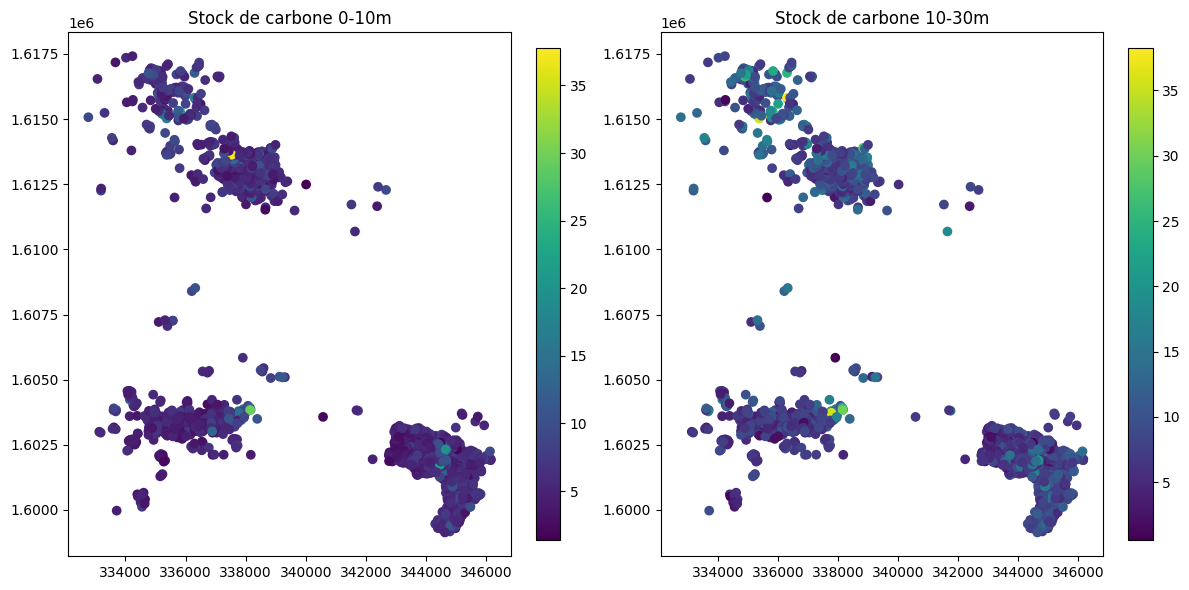

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(x_coords_10, y_coords_10, c=Carbon_10)
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Stock de carbone 0-10m')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(x_coords_30, y_coords_30, c=Carbon_30)
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Stock de carbone 10-30m')

plt.tight_layout()
plt.show()


In [ ]:
!pip install scikit-gstat -q
!pip install gstools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 7.1 MB/s eta 0:00:00


In [ ]:
data10 = {
    'x': x_coords_10,
    'y': y_coords_10,
    'carbon_stock': Carbon_10
}

data30 = {
    'x': x_coords_30,
    'y': y_coords_30,
    'carbon_stock': Carbon_30
}

df_10 = pd.DataFrame(data10)
df_30 = pd.DataFrame(data30)

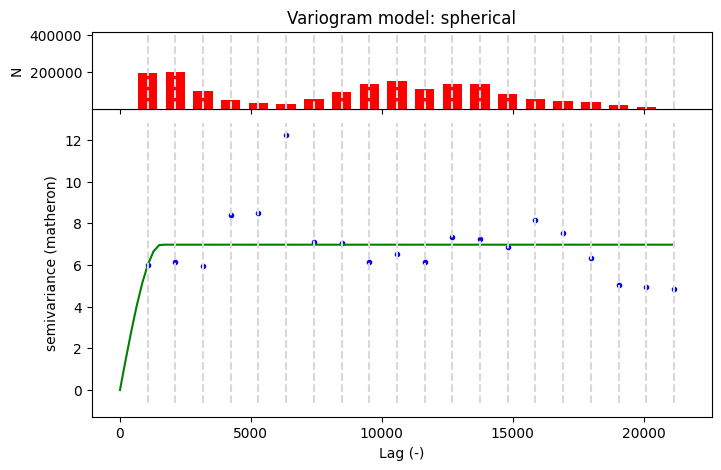

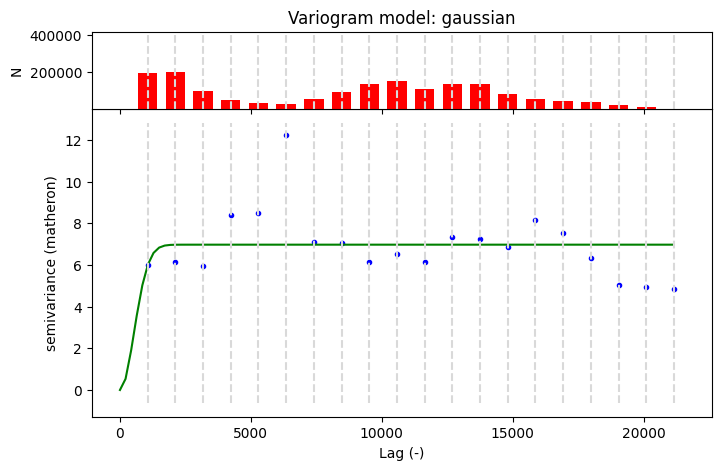

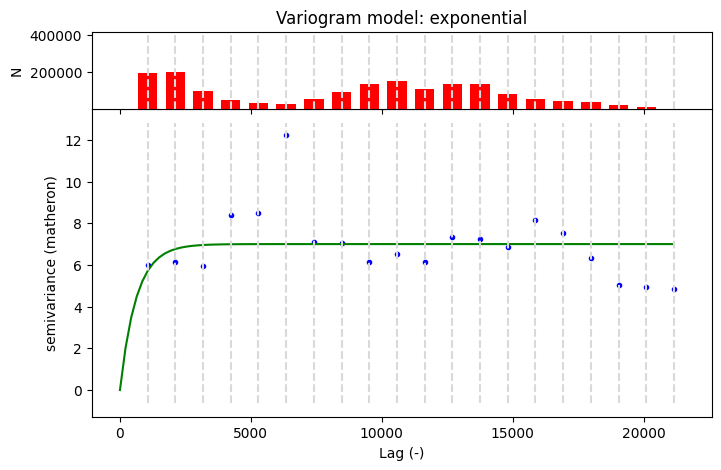

spherical model RMSE: 1.581250482757408
gaussian model RMSE: 1.5811775074107932
exponential model RMSE: 1.5762236786246984


In [ ]:
from skgstat import Variogram

# Création du variogramme
coords = df_10[['x', 'y']].values
values = df_10['carbon_stock'].values

# Liste des modèles disponibles dans scikit-gstat
models = ['spherical', 'gaussian', 'exponential']

# Dictionnaire pour stocker les erreurs des modèles
model_errors = {}

for model in models:
    V = Variogram(coords, values, model=model, n_lags=20)
    model_errors[model] = V.rmse

    # Plot du variogramme ajusté
    V.plot()
    plt.title(f"Variogram model: {model}")
    plt.show()

# Affichage des erreurs pour chaque modèle
for model, error in model_errors.items():
    print(f"{model} model RMSE: {error}")


In [ ]:
best_model = min(model_errors, key=model_errors.get)
print(f"The best model is: {best_model} with RMSE: {model_errors[best_model]}")

The best model is: exponential with RMSE: 1.5762236786246984


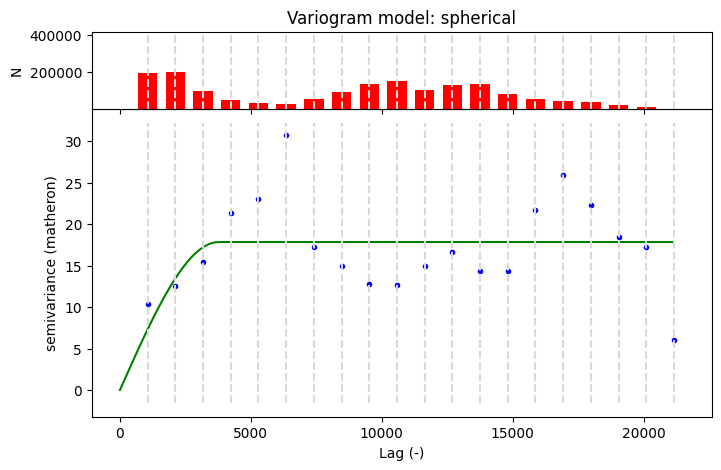

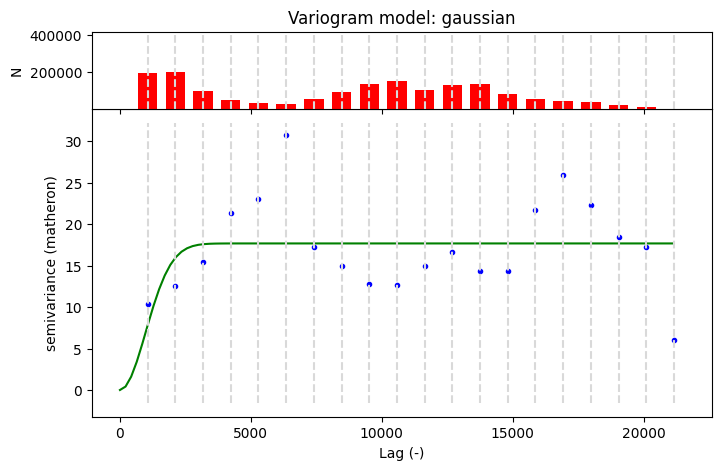

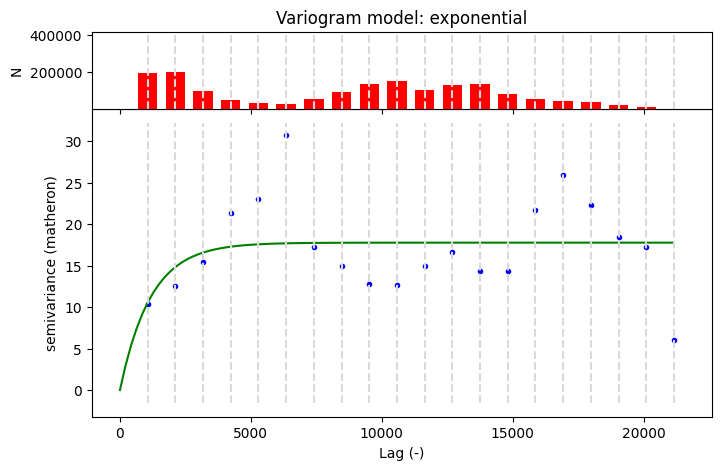

spherical model RMSE: 5.257965668631594
gaussian model RMSE: 5.3068580576452
exponential model RMSE: 5.264748498684166


In [ ]:
from skgstat import Variogram

# Création du variogramme
coords = df_30[['x', 'y']].values
values = df_30['carbon_stock'].values

# Liste des modèles disponibles dans scikit-gstat
models = ['spherical', 'gaussian', 'exponential']

# Dictionnaire pour stocker les erreurs des modèles
model_errors = {}

for model in models:
    V = Variogram(coords, values, model=model, n_lags=20)
    model_errors[model] = V.rmse

    # Plot du variogramme ajusté
    V.plot()
    plt.title(f"Variogram model: {model}")
    plt.show()

# Affichage des erreurs pour chaque modèle
for model, error in model_errors.items():
    print(f"{model} model RMSE: {error}")


In [ ]:
best_model = min(model_errors, key=model_errors.get)
print(f"The best model is: {best_model} with RMSE: {model_errors[best_model]}")

The best model is: spherical with RMSE: 4.086156800442789


In [ ]:
coords_10 = df_10[['x', 'y']].values
values_10 = df_10['carbon_stock'].values

coords_30 = df_30[['x', 'y']].values
values_30 = df_30['carbon_stock'].values

# Créer un objet Variogramme à partir des données
V10 = Variogram(coords_10, values_10, model='exponential', normalize=True)
V30 = Variogram(coords_30, values_30, model='spherical', normalize=True)

# Convertir le Variogramme en Krigeage avec le modèle Matern
krige10 = V10.to_gs_krige()
krige30 = V30.to_gs_krige()

# Créer une grille régulière pour l'interpolation
x_grid_10 = np.linspace(min(df_10['x']), max(df_10['x']), 100)
y_grid_10 = np.linspace(min(df_10['y']), max(df_10['y']), 100)

x_grid_30 = np.linspace(min(df_30['x']), max(df_30['x']), 100)
y_grid_30 = np.linspace(min(df_30['y']), max(df_30['y']), 100)

# Appliquer le krigeage sur la grille
field_10, variance_10 = krige10.structured((x_grid_10, y_grid_10))
field_30, variance_30 = krige30.structured((x_grid_30, y_grid_30))

# Utiliser les mêmes bornes pour l'affichage
vmin_10 = np.min(field_10)
vmax_10 = np.max(field_10)

vmin_30 = np.min(field_30)
vmax_30 = np.max(field_30)

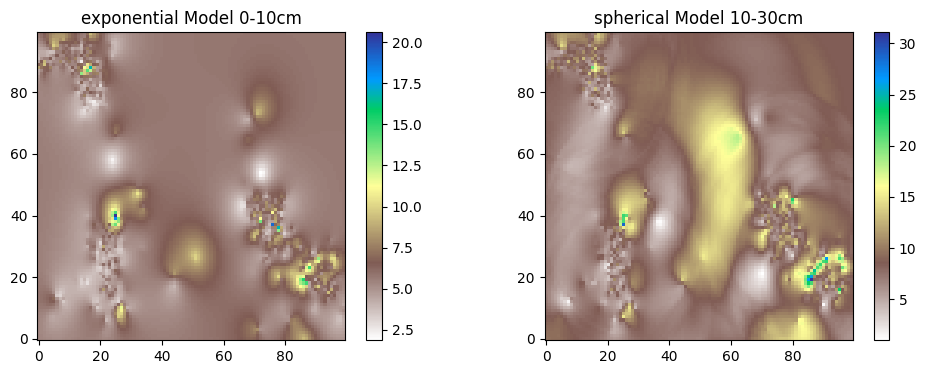

In [ ]:
# Afficher le résultat
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Premier sous-graphe pour le modèle exponential 0-10cm
im1 = ax[0].imshow(field_10, origin='lower', cmap='terrain_r', vmin=vmin_10, vmax=vmax_10)
ax[0].set_title('exponential Model 0-10cm')
fig.colorbar(im1, ax=ax[0], fraction=0.05)

# Deuxième sous-graphe pour le modèle spherical 10-30cm
im2 = ax[1].imshow(field_30, origin='lower', cmap='terrain_r', vmin=vmin_30, vmax=vmax_30)
ax[1].set_title('spherical Model 10-30cm')
fig.colorbar(im2, ax=ax[1], fraction=0.05)

plt.show()


In [ ]:
# Calculer l'erreur de prédiction comme l'écart-type de la variance
prediction_error10 = np.sqrt(variance_10)
prediction_error30 = np.sqrt(variance_30)

# Utiliser les mêmes bornes pour l'affichage de l'erreur
vmin_error10 = np.min(prediction_error10)
vmax_error10 = np.max(prediction_error10)

vmin_error30 = np.min(prediction_error30)
vmax_error30 = np.max(prediction_error30)

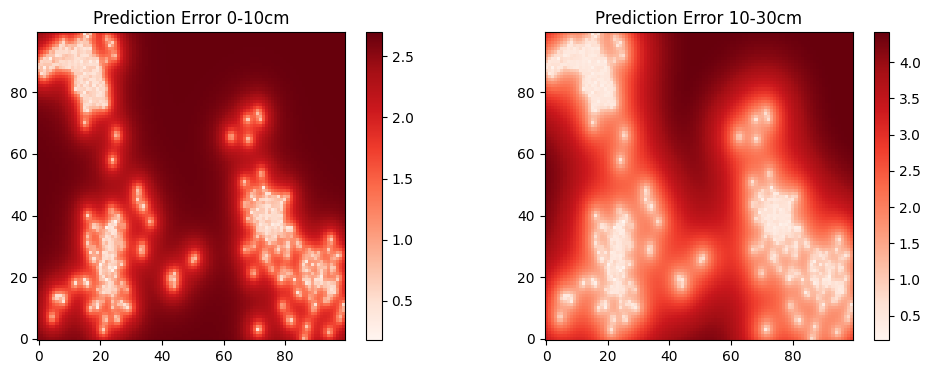

In [ ]:
# Afficher l'erreur de prédiction
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Premier sous-graphe pour l'erreur de prédiction 0-10cm
im1 = ax[0].imshow(prediction_error10, origin='lower', cmap='Reds', vmin=vmin_error10, vmax=vmax_error10)
ax[0].set_title('Prediction Error 0-10cm')
fig.colorbar(im1, ax=ax[0], fraction=0.05)

# Deuxième sous-graphe pour l'erreur de prédiction 10-30cm
im2 = ax[1].imshow(prediction_error30, origin='lower', cmap='Reds', vmin=vmin_error30, vmax=vmax_error30)
ax[1].set_title('Prediction Error 10-30cm')
fig.colorbar(im2, ax=ax[1], fraction=0.05)

plt.show()


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.799103739996896
Full Sill: 6.854125769566629
Range: 3282.7371924854215
Nugget: 5.055022029569733 



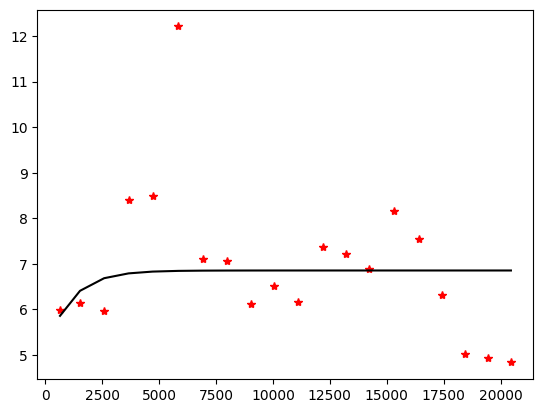

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 9.084332900817186
Full Sill: 16.974367295756956
Range: 3929.0752718625936
Nugget: 7.8900343949397715 



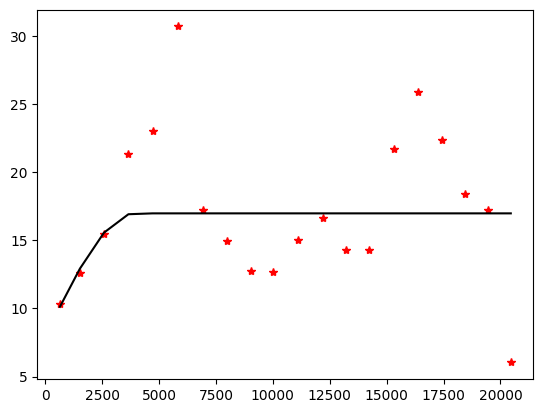

Calculating statistics on variogram model fit...


In [ ]:
OK1 = OrdinaryKriging(
    x_coords_10,
    y_coords_10,
    Carbon_10,
    variogram_model='exponential',
    verbose=True,
    enable_plotting=True,
    nlags=20,
)

OK2 = OrdinaryKriging(
    x_coords_30,
    y_coords_30,
    Carbon_30,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True,
    nlags=20,
)

In [ ]:
OK1.variogram_model_parameters, OK2.variogram_model_parameters

(array([1.79910374e+00, 3.28273719e+03, 5.05502203e+00]),
 array([   9.0843329 , 3929.07527186,    7.89003439]))

In [ ]:
# Définir une grille de points pour l'interpolation
gridx_10 = np.linspace(min(x_coords_10), max(x_coords_10), 100)
gridy_10 = np.linspace(min(y_coords_10), max(y_coords_10), 100)

gridx_30 = np.linspace(min(x_coords_30), max(x_coords_30), 100)
gridy_30 = np.linspace(min(y_coords_30), max(y_coords_30), 100)

# Effectuer l'interpolation sur la grille
z_interp1, ss1 = OK1.execute('grid', gridx_10, gridy_10)

z_interp2, ss2 = OK2.execute('grid', gridx_30, gridy_30)

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [ ]:
z_interp1.shape,ss1.shape,z_interp2.shape,ss2.shape

((100, 100), (100, 100), (100, 100), (100, 100))

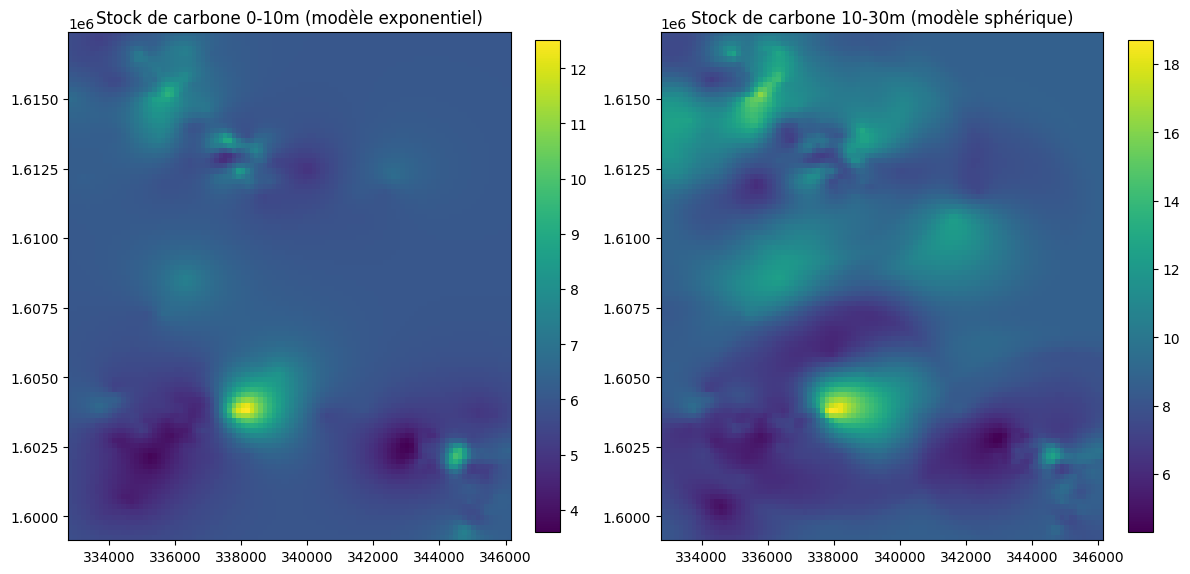

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].imshow(z_interp1, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[0].scatter(x, y, c=carbon_1, marker='.')
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Stock de carbone 0-10m (modèle exponentiel)')

# Affichage du deuxième graphique
cax2 = axs[1].imshow(z_interp2, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[1].scatter(x, y, c=carbon_2, marker='.')
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Stock de carbone 10-30m (modèle sphérique)')

plt.tight_layout()
plt.show()


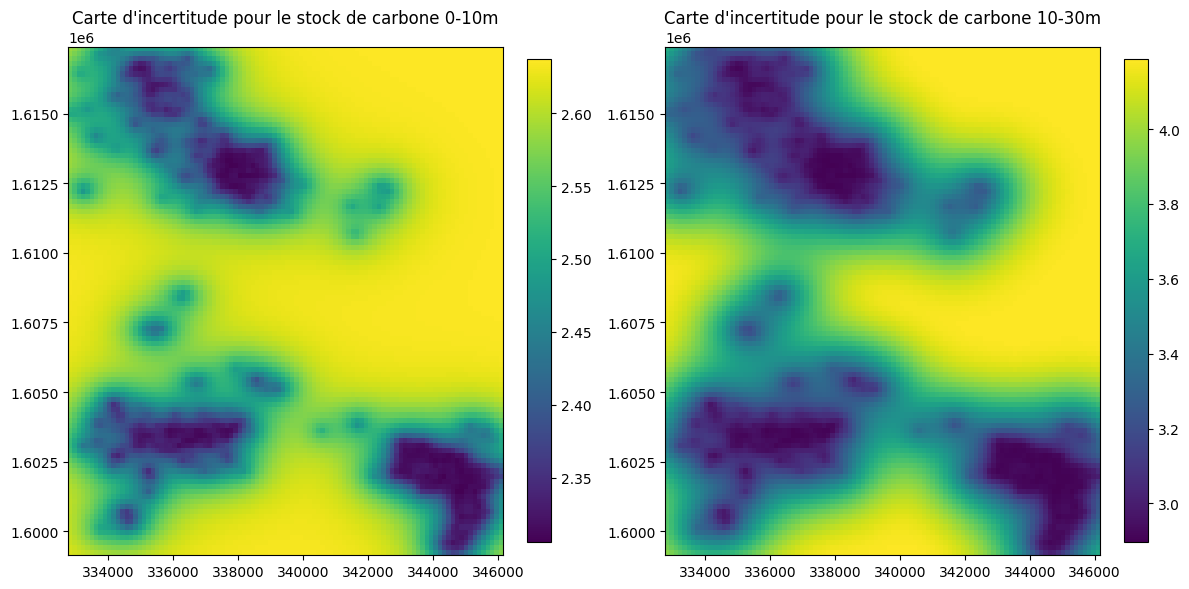

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].imshow(np.sqrt(ss1), extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[0].scatter(x, y, c=carbon_1, marker='.')
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Carte d\'incertitude pour le stock de carbone 0-10m')

# Affichage du deuxième graphique
cax2 = axs[1].imshow(np.sqrt(ss2), extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[1].scatter(x, y, c=carbon_2, marker='.')
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Carte d\'incertitude pour le stock de carbone 10-30m')

plt.tight_layout()
plt.show()
